In [1]:
#MileStone Project 2:SkimLit medical Papers Abstraction

In [2]:
#Get dataset(PubMed 200k RCT)
#Since the dataset we need is in github already we will clone the repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.


In [3]:
#First we will use the PubNet_20K dataset and then upscale it to PubNet_200K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [6]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
#Read training lines
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
#preprocessing text lines into a neat dictionary
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename,reads in contents and sorts through each line,
  extractingthings like target label,the text of the sentence,
  how many sentences are there in the current abstract and what sentence number
  the target line is.

  """
  input_lines=get_lines(filename)
  abstract_lines=""#create an empty abstract
  abstract_samples=[]#dictionary
  for line in input_lines:
    if line.startswith('###'):#Check if Line is ID line
          abstract_id=line
          abstract_lines=""#reset abstract line
    elif line.isspace():#Check if line is a new line
          abstract_line_split=abstract_lines.splitlines()#split abstract into seperate lines

          #Iterate through each line in a single abstract and count them at the same time
          for abstract_line_number,abstract_line in enumerate(abstract_line_split):
            line_data={}#create an empty dictionary for each line
            target_text_split=abstract_line.split("\t")#split target label and text
            line_data["target"]=target_text_split[0]#get target label
            line_data["text"]=target_text_split[1].lower()#make the remaining text to lower case
            line_data["line_number"]=abstract_line_number#what line it appears in the abstract
            line_data["total_lines"]=len(abstract_line_split)-1
            abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples



In [10]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")#dev is another name for validation dataset
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
train_sentences=train_df["text"].to_numpy()
val_sentences=val_df["text"].to_numpy()
test_sentences=test_df["text"].to_numpy()

In [14]:
#Distributions of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

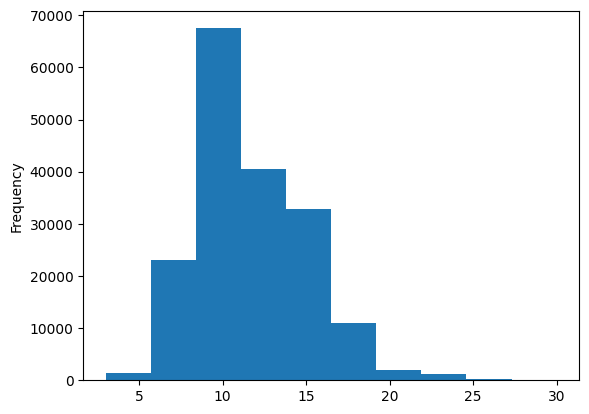

In [15]:
#check of length of different lines
train_df.total_lines.plot.hist()

In [16]:
#Make Numeric Labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
#check one hot encoded labels
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
#Label encoding for ML models
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_label_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoded=label_encoder.fit_transform(val_df["target"].to_numpy())
test_label_encoded=label_encoder.fit_transform(test_df["target"].to_numpy())

#check label encoded labels
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
#decoding classes from labels
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [19]:
#Model 0:Baseline Model(tf-idf Naive Bayes)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(X=train_sentences,y=train_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
#evaluate model_0 on validation data
model_0.score(val_sentences,val_label_encoded)

0.7218323844829869

In [21]:
#make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
#Download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-17 14:56:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-17 14:56:55 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results
baseline_results=calculate_results(val_label_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
#Preparing data for deep learning models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
#how long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

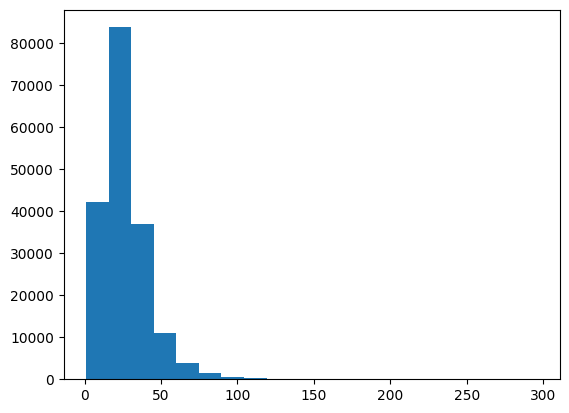

In [26]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [27]:
#how long of a sentence length covers 95% of data?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [28]:
#Max sequence length
max(sent_lens)

296

In [29]:
#maximum words in vocabulary is taken from paper
max_tokens=68000

In [30]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=output_seq_len,
                                  )

In [31]:
#Adapt text vectorizer to training data(FIrst fit in training data and then testing data later(because test data is not supposed to be seen))
text_vectorizer.adapt(train_sentences)

In [32]:
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of the text:{len(target_sentence.split())}")
print(f"\nVectorized Text:{text_vectorizer([target_sentence])}")

Text:
the total effective rate , the stool property and state , the quality of life ( qol ) , and tcm syndrome efficacy were assessed by ibs bowel symptom severity scale ( ibs-bss ) , ibs defecation state questionnaire ( ibs-dsq ) , ibs quality of life questionnaire ( ibs-qol ) , and traditional chinese medicine pattern curative effect scoring system ( tcm-pes ) before and after treatment .

Length of the text:69

Vectorized Text:[[    2    76   137    78     2  2232 13042     3   917     2   141     4
    195   609     3  2544   392    79     9   113    22  2993   980   448
    332   158 38066  2993  5023   917   325 55514  2993   141     4   195
    325 22907     3   803   856   941  1376  2249    70  2359   355 33876
    129     3    21    19     0     0     0]]


In [33]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most common words in vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most common words in vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
#configuration of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [35]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True,
                             name="EmbeddingLayer")

In [36]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embeddding\n{embedded_sentence}")
print(f"Embedded Sentence shape:{embedded_sentence.shape}")

Sentence before vectorization:
the total effective rate , the stool property and state , the quality of life ( qol ) , and tcm syndrome efficacy were assessed by ibs bowel symptom severity scale ( ibs-bss ) , ibs defecation state questionnaire ( ibs-dsq ) , ibs quality of life questionnaire ( ibs-qol ) , and traditional chinese medicine pattern curative effect scoring system ( tcm-pes ) before and after treatment .

Sentence after vectorization (before embedding):
[[    2    76   137    78     2  2232 13042     3   917     2   141     4
    195   609     3  2544   392    79     9   113    22  2993   980   448
    332   158 38066  2993  5023   917   325 55514  2993   141     4   195
    325 22907     3   803   856   941  1376  2249    70  2359   355 33876
    129     3    21    19     0     0     0]]
Sentence after embeddding
[[[-2.9968893e-02 -3.6862336e-02 -7.5101852e-06 ...  4.7184143e-02
   -2.4757242e-02 -1.2112569e-02]
  [ 2.0644043e-02 -1.1604629e-02  2.1487180e-02 ... -7.4136741

In [37]:
#creating datasets for fast loading
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
#Take tensorSliceDatasets and turn them into prefetched Datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [39]:
#Model 1:Conv1D with token embedding
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(filters=64,
                kernel_size=5,
                strides=1,
                activation="relu",
                padding="same")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

In [40]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 EmbeddingLayer (Embedding)  (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
history_1=model_1.fit(train_dataset,
                      epochs=3,
                      steps_per_epoch=int(0.1*len(train_dataset)),
                      validation_data=valid_dataset,
                      validation_steps=int(0.1*(len(valid_dataset))))

Epoch 1/3
562/562 [==============================] - 75s 131ms/step - loss: 0.9126 - accuracy: 0.6367 - val_loss: 0.6843 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 76s 135ms/step - loss: 0.6592 - accuracy: 0.7542 - val_loss: 0.6343 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 75s 133ms/step - loss: 0.6216 - accuracy: 0.7721 - val_loss: 0.6018 - val_accuracy: 0.7829


In [43]:
#Evaluate on the whole dataset
model_1_score=model_1.evaluate(valid_dataset)
model_1_score

945/945 [==============================] - 5s 6ms/step - loss: 0.6041 - accuracy: 0.7832


[0.6040782332420349, 0.7832318544387817]

In [44]:
#Make predictions with Model 1
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.03032005e-01, 1.87678039e-01, 9.53463241e-02, 2.85251707e-01,
         2.86920276e-02],
        [4.66050863e-01, 2.50876039e-01, 1.12400595e-02, 2.65299678e-01,
         6.53332798e-03],
        [1.40890226e-01, 5.46948146e-03, 1.58382906e-03, 8.52018297e-01,
         3.81649115e-05],
        ...,
        [2.92180698e-06, 7.93219020e-04, 5.90188603e-04, 2.46420768e-06,
         9.98611212e-01],
        [5.59455305e-02, 4.36082959e-01, 1.10931948e-01, 6.61875829e-02,
         3.30851972e-01],
        [1.87670782e-01, 6.41355872e-01, 4.02718224e-02, 4.96925116e-02,
         8.10089931e-02]], dtype=float32),
 (30212, 5))

In [45]:
#convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
model_1_results=calculate_results(val_label_encoded,model_1_preds)
model_1_results

{'accuracy': 78.32318284125513,
 'precision': 0.7804471447575612,
 'recall': 0.7832318284125513,
 'f1': 0.7809721379824022}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [48]:
#Feature extraction with pretrained token embeddings
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
random_train_sentence=random.choice(train_sentences)
print(f"Random training sentence:\n{random_train_sentence}\n")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}(truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
phase ii will be a prospective , randomized study in which we compare current unstructured transition ( control group ) to structured transition ( intervention group ) .

Sentence after embedding:
[ 0.06400864 -0.0676434  -0.0041742   0.03272926 -0.06275696 -0.0311598
  0.03821878 -0.06305636 -0.02580927  0.05337731  0.0588382   0.00065307
  0.02693223 -0.00848442  0.00373754 -0.06803134 -0.07101437 -0.03403919
  0.01420564 -0.07749717 -0.04492051  0.05387269 -0.04892249 -0.02601127
 -0.01438146 -0.06335007  0.06765229  0.07128286 -0.00657105 -0.03626917](truncated output)...

Length of sentence embedding:
512


In [50]:
#Model 2:Pretrained embedding layer
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation="relu")(pretrained_embedding)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs,name="USE_feature_extraction")

In [51]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
model_2.summary()

Model: "USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.10*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.10*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9208 - accuracy: 0.6500 - val_loss: 0.7981 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7707 - accuracy: 0.7005 - val_loss: 0.7568 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7546 - accuracy: 0.7114 - val_loss: 0.7411 - val_accuracy: 0.7114


In [54]:
#evaluate on whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7426 - accuracy: 0.7133


[0.7426355481147766, 0.7133258581161499]

In [55]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.42399797, 0.386481  , 0.00212124, 0.1812019 , 0.00619783],
       [0.3586339 , 0.47675726, 0.00352427, 0.15834832, 0.00273618],
       [0.23569158, 0.16877776, 0.01881751, 0.53527796, 0.0414351 ],
       ...,
       [0.00193462, 0.00656726, 0.05369894, 0.00097641, 0.9368228 ],
       [0.0049422 , 0.05015905, 0.17477648, 0.00135685, 0.7687654 ],
       [0.2030431 , 0.24324681, 0.48806298, 0.00718972, 0.05845732]],
      dtype=float32)

In [56]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
model_2_results=calculate_results(val_label_encoded,model_2_preds)
model_2_results

{'accuracy': 71.33258307957104,
 'precision': 0.7137349039628171,
 'recall': 0.7133258307957103,
 'f1': 0.7102076851734521}

In [58]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [59]:
#Model 3:Conv1D with character token embedding
def split_chars(text):
  return " ".join(list(text))

#Text Splitting non-character level sequence into characters
split_chars(random_train_sentence)

'p h a s e   i i   w i l l   b e   a   p r o s p e c t i v e   ,   r a n d o m i z e d   s t u d y   i n   w h i c h   w e   c o m p a r e   c u r r e n t   u n s t r u c t u r e d   t r a n s i t i o n   (   c o n t r o l   g r o u p   )   t o   s t r u c t u r e d   t r a n s i t i o n   (   i n t e r v e n t i o n   g r o u p   )   .'

In [60]:
#split sequence-level data splits into character level data splits
train_chars=[split_chars(sentence)for sentence in train_sentences]
val_chars=[split_chars(sentence)for sentence in val_sentences]
test_chars=[split_chars(sentence)for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
#Average number of characters in a sequence
char_lens=[len(sentence)for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

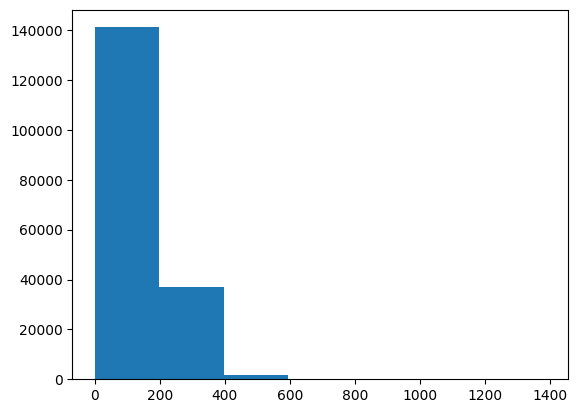

In [62]:
#Check distribution of sequences in character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [63]:
#Find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [64]:
#Get all keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
NUM_CHAR_TOKENS=len(alphabet)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name="char_vectorizer")

In [66]:
#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [67]:
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab:{len(char_vocab)}")
print(f"5 most common characters:{char_vocab[:5]}")
print(f"5 least common characters:{char_vocab[-5:]}")

Number of different characters in character vocab:28
5 most common characters:['', '[UNK]', 'e', 't', 'i']
5 least common characters:['k', 'x', 'z', 'q', 'j']


In [68]:
#testing character vectorizer
random_train_chars=random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random trained chars:{len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars:{len(vectorized_chars[0])}")

Charified text:
t h i s   i s   a   r a n d o m i z e d   c o n t r o l l e d   t r i a l   w i t h   a   @   @   m i x e d   b e t w e e n - w i t h i n   s u b j e c t s   d e s i g n   .
Length of random trained chars:73

Vectorized chars:
[[ 3 13  4  9  4  9  5  8  5  6 10  7 15  4 25  2 10 11  7  6  3  8  7 12
  12  2 10  3  8  4  5 12 20  4  3 13  5 15  4 24  2 10 22  2  3 20  2  2
   6 20  4  3 13  4  6  9 16 22 27  2 11  3  9 10  2  9  4 18  6  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

In [69]:
#create a character level embedding
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25,#size of char embedding in paper
                            mask_zero=True,
                            name="char_embed")

In [70]:
#test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars:\n{char_embed_example}")
print(f"Character embed shape:{char_embed_example.shape}")

Charified text:
 t h i s   i s   a   r a n d o m i z e d   c o n t r o l l e d   t r i a l   w i t h   a   @   @   m i x e d   b e t w e e n - w i t h i n   s u b j e c t s   d e s i g n   .

Embedded chars:
[[[-0.03274802 -0.03517413  0.03695414 ...  0.02271887  0.03125094
   -0.00967721]
  [-0.00062693  0.02585895  0.02452096 ...  0.01886066 -0.0452579
   -0.02701104]
  [-0.03926166 -0.0384773   0.03884026 ...  0.0087489   0.021515
   -0.00123436]
  ...
  [ 0.00269469  0.04253585 -0.00228634 ... -0.00951475  0.03334243
    0.03963288]
  [ 0.00269469  0.04253585 -0.00228634 ... -0.00951475  0.03334243
    0.03963288]
  [ 0.00269469  0.04253585 -0.00228634 ... -0.00951475  0.03334243
    0.03963288]]]
Character embed shape:(1, 290, 25)


In [71]:
#Model 3:Conv1D model with character level tokenization
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectorized_inputs=char_vectorizer(inputs)
embedded_char_inputs=char_embed(char_vectorized_inputs)
x=layers.Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(embedded_char_inputs)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="character_level_Conv1D")

In [72]:
model_3.summary()

Model: "character_level_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)      

In [73]:
#create char level datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
history_model_3=model_3.fit(train_char_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.10*len(train_char_dataset)),
                            validation_data=val_char_dataset,
                            validation_steps=int(0.10*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 26ms/step - loss: 1.2479 - accuracy: 0.4984 - val_loss: 1.0208 - val_accuracy: 0.5974
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9870 - accuracy: 0.6095 - val_loss: 0.9265 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.9147 - accuracy: 0.6453 - val_loss: 0.8580 - val_accuracy: 0.6642


In [76]:
#evaluate on full dataset
model_3_score=model_3.evaluate(val_char_dataset)
model_3_score

945/945 [==============================] - 7s 7ms/step - loss: 0.8797 - accuracy: 0.6586


[0.8797458410263062, 0.6585793495178223]

In [77]:
#make predictions on validation data with model 3
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

945/945 [==============================] - 8s 8ms/step


array([[2.88654506e-01, 2.72881418e-01, 7.12918416e-02, 3.38558257e-01,
        2.86138877e-02],
       [2.93321848e-01, 5.60570002e-01, 5.61443111e-03, 9.35634673e-02,
        4.69301641e-02],
       [1.27056688e-01, 3.28544617e-01, 2.46777505e-01, 1.67845279e-01,
        1.29775926e-01],
       [8.61082878e-03, 2.40578745e-02, 9.01897013e-01, 1.17830625e-02,
        5.36512919e-02],
       [3.83895412e-02, 1.31315827e-01, 5.96891522e-01, 4.95376587e-02,
        1.83865428e-01],
       [4.63067787e-04, 8.84792826e-04, 8.06838274e-01, 4.22742509e-04,
        1.91391081e-01],
       [5.08266781e-03, 1.56495329e-02, 6.20258689e-01, 7.60731241e-03,
        3.51401836e-01],
       [2.20334366e-01, 3.33927959e-01, 4.52228747e-02, 3.49341333e-01,
        5.11733815e-02],
       [1.99074764e-03, 2.02136151e-02, 2.01090261e-01, 1.01973824e-02,
        7.66507983e-01],
       [1.39561802e-01, 2.62233227e-01, 1.23946391e-01, 3.85388345e-01,
        8.88701528e-02]], dtype=float32)

In [78]:
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [79]:
model_3_results=calculate_results(val_label_encoded,model_3_preds)
model_3_results

{'accuracy': 65.85793724347941,
 'precision': 0.6540949273034166,
 'recall': 0.6585793724347941,
 'f1': 0.648618803784914}

In [80]:
#1.setup token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,outputs=token_output)

#2.setup character inputs/model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

#3.Concatenate token and char inputs(create hybrid token embedding)
token_char_concat=layers.Concatenate(name="tokens_char_hybrid")([token_model.output,char_model.output])

#4.Create output layers and adding dropout
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_layer_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_layer_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

#5.COnstruct model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name="model_4_token_and_char_embeddings")

In [81]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

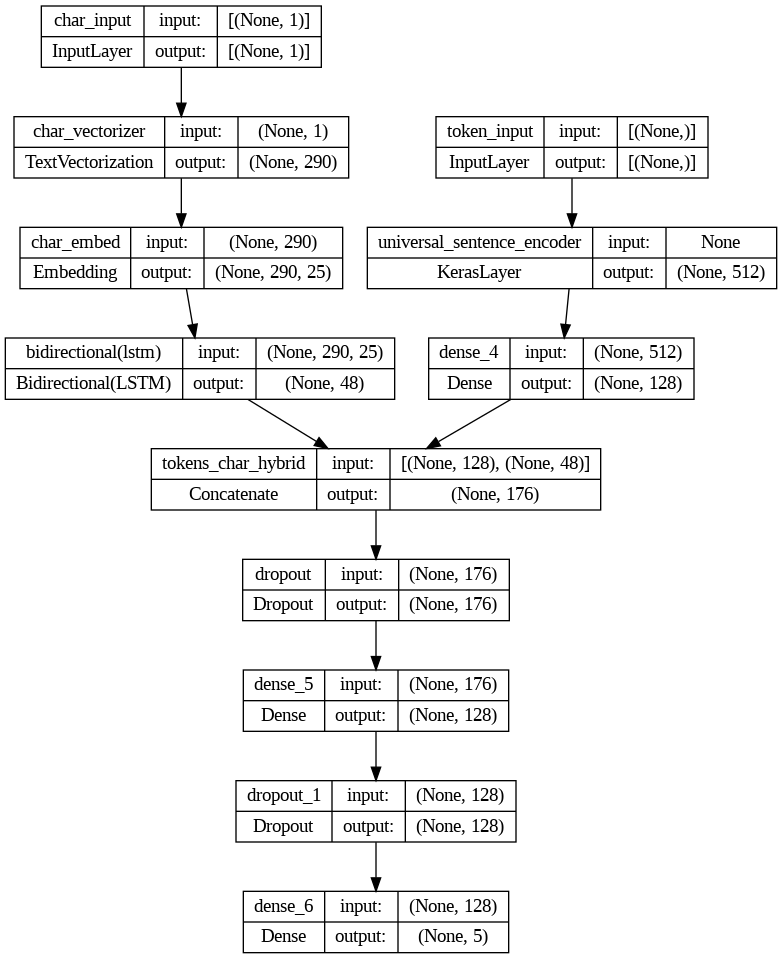

In [82]:
#plot hybrid character and token model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [83]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [84]:
train_token_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_label=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_dataset=tf.data.Dataset.zip((train_token_char_data,train_token_char_label))

#prefetch and batch data
train_char_token_dataset=train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_label=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_dataset=tf.data.Dataset.zip((val_token_char_data,val_token_char_label))
val_char_token_dataset=val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
#check out our training char and token embedding dataset
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [86]:
#fiiting model 4
history_model_4=model_4.fit(train_char_token_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.10*len(train_char_token_dataset)),
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.10*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 238s 406ms/step - loss: 0.9863 - accuracy: 0.6060 - val_loss: 0.7774 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 256s 455ms/step - loss: 0.8035 - accuracy: 0.6881 - val_loss: 0.7248 - val_accuracy: 0.7197
Epoch 3/3
562/562 [==============================] - 263s 469ms/step - loss: 0.7755 - accuracy: 0.7030 - val_loss: 0.6989 - val_accuracy: 0.7380


In [87]:
#evaluate on the whole validation dataset
model_4_score=model_4.evaluate(val_char_token_dataset)
model_4_score

945/945 [==============================] - 95s 101ms/step - loss: 0.7014 - accuracy: 0.7333


[0.7013528347015381, 0.7333179116249084]

In [88]:
#make predictions
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 [==============================] - 94s 96ms/step


array([[3.84891897e-01, 3.96586239e-01, 6.15090644e-03, 2.05264762e-01,
        7.10622361e-03],
       [3.71566147e-01, 4.22930509e-01, 3.09459725e-03, 2.00663134e-01,
        1.74552621e-03],
       [3.39306206e-01, 1.41919822e-01, 7.04356506e-02, 4.10133272e-01,
        3.82050239e-02],
       [1.20256562e-02, 1.73211973e-02, 8.49702954e-01, 6.91508222e-03,
        1.14035055e-01],
       [2.95507461e-02, 5.60697131e-02, 6.80777133e-01, 9.96516272e-03,
        2.23637238e-01],
       [5.96194994e-04, 1.61738833e-03, 6.95337594e-01, 3.12362099e-04,
        3.02136451e-01],
       [2.59387400e-03, 1.78982895e-02, 4.86702740e-01, 1.47057755e-03,
        4.91334528e-01],
       [3.67603032e-03, 2.16401611e-02, 4.59813297e-01, 1.65869447e-03,
        5.13211787e-01],
       [5.60680521e-04, 1.22282654e-02, 3.64450589e-02, 4.03383456e-04,
        9.50362682e-01],
       [3.11896622e-01, 4.42860216e-01, 4.05357480e-02, 1.28588483e-01,
        7.61189014e-02]], dtype=float32)

In [89]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [90]:
model_4_results=calculate_results(val_label_encoded,model_4_preds)
model_4_results

{'accuracy': 73.33178869323447,
 'precision': 0.7332044940979643,
 'recall': 0.7333178869323448,
 'f1': 0.7312292561580028}

In [91]:
#create positional embeddings
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

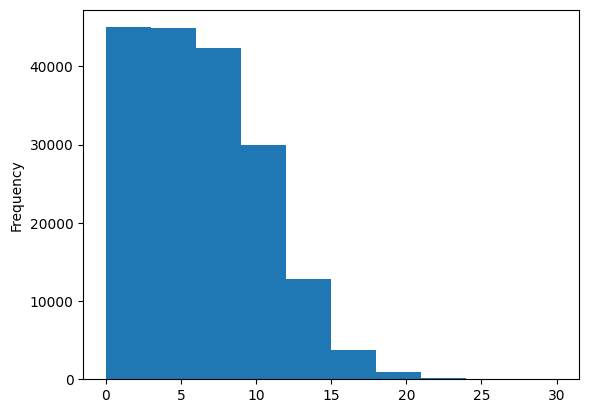

In [92]:
#check distribution of line number column
train_df.line_number.plot.hist()

In [93]:
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [94]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

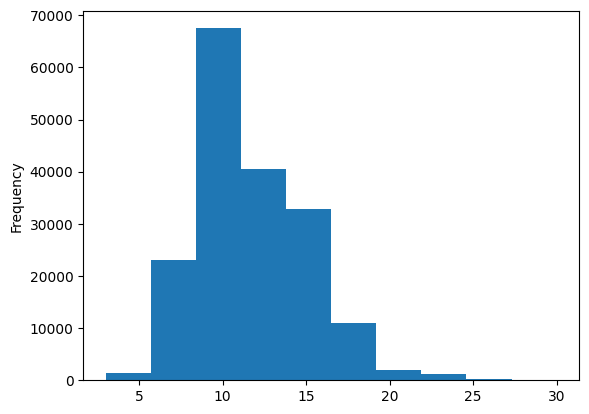

In [95]:
train_df.total_lines.plot.hist()

In [96]:
np.percentile(train_df.total_lines,95)

18.0

In [97]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [98]:
#Building a tribid embedding model
#1.Token inputs
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

In [99]:
#2.Char inputs
char_inputs=layers.Input(shape=[],dtype=tf.string,name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

In [100]:
#3.Line number inputs
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
line_number_embedded=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,line_number_embedded)

In [101]:
#4.Total lines inputs
total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_line_input")
total_lines_embedded=layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model=tf.keras.Model(total_lines_inputs,total_lines_embedded)

In [102]:
#5.Combining token and char inputs
combined_embeddings=layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,char_model.output])
z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

In [103]:
#6.combining positional and combined token and char inputs
tribrid_embeddings=layers.Concatenate(name="char_token_positional_embeddings")([line_number_model.output,total_lines_model.output,z])

In [104]:
#Create output layer
output_layer=layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embeddings)

In [105]:
#putting everything together
model_5=tf.keras.Model(inputs=[line_number_model.input,
                              total_lines_model.input,
                              token_model.input,
                              char_model.input],
                       outputs=output_layer,name="tribrid_embedding_model")

In [106]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

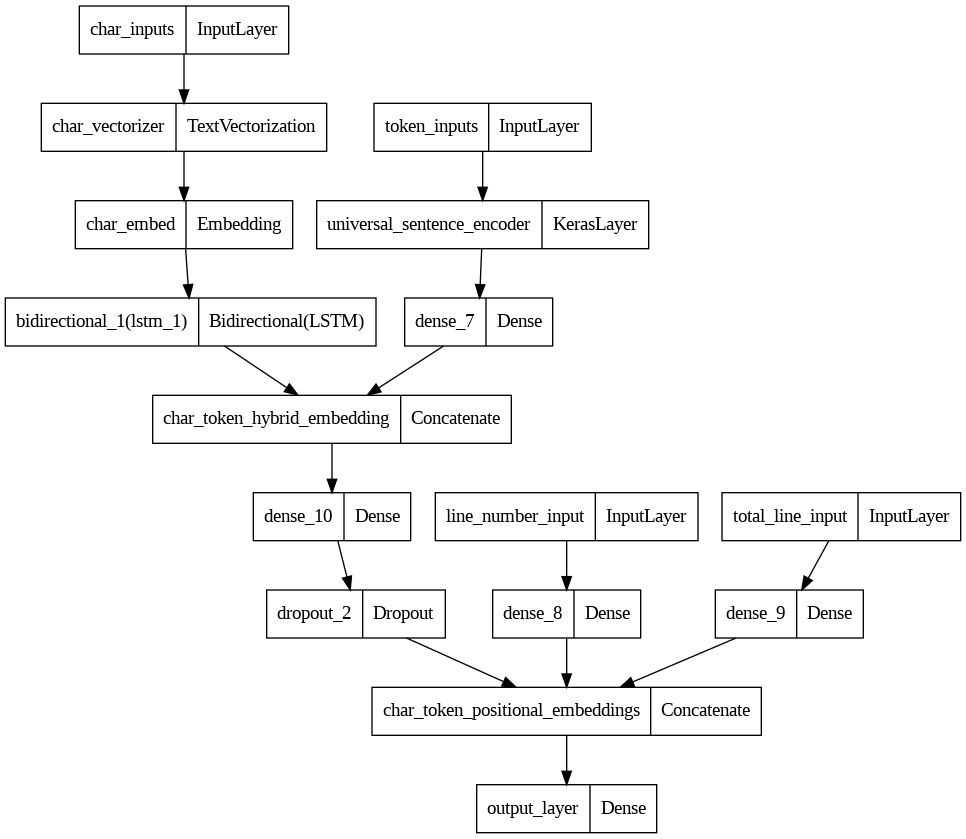

In [107]:
#Plot model 5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [108]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [109]:
#create tribrid embeddings datasets
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_label=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_label))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_label=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_label))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [110]:
#check input shapes
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [111]:
#fitting an devaluating our tribrid model
history_model_5=model_5.fit(train_char_token_pos_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.10*len(train_char_token_pos_dataset)),
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.10*len(val_char_token_pos_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 227s 380ms/step - loss: 1.0951 - accuracy: 0.7264 - val_loss: 0.9842 - val_accuracy: 0.8005
Epoch 2/3
562/562 [==============================] - 203s 361ms/step - loss: 0.9668 - accuracy: 0.8171 - val_loss: 0.9508 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 206s 367ms/step - loss: 0.9508 - accuracy: 0.8223 - val_loss: 0.9402 - val_accuracy: 0.8295


In [112]:
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 77s 78ms/step


array([[0.49444136, 0.11729641, 0.01355063, 0.35629407, 0.01841732],
       [0.5155244 , 0.09319401, 0.06088124, 0.31515375, 0.01524664],
       [0.27609557, 0.11595453, 0.12530944, 0.41183308, 0.07080737],
       ...,
       [0.03208243, 0.11066223, 0.04294965, 0.03170332, 0.7826024 ],
       [0.02834151, 0.29369214, 0.08946627, 0.02580501, 0.5626951 ],
       [0.19955982, 0.5805563 , 0.11771996, 0.04354452, 0.05861942]],
      dtype=float32)

In [113]:
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [114]:
model_5_results=calculate_results(val_label_encoded,model_5_preds)
model_5_results

{'accuracy': 83.38077585065537,
 'precision': 0.8325723242110707,
 'recall': 0.8338077585065536,
 'f1': 0.8324938784926226}

In [115]:
model_4_results

{'accuracy': 73.33178869323447,
 'precision': 0.7332044940979643,
 'recall': 0.7333178869323448,
 'f1': 0.7312292561580028}

In [116]:
#comparing model results
all_models_results=pd.DataFrame({"baseline":baseline_results,
                                 "model_1_custom_token_embedding":model_1_results,
                                 "model_2_pretrained_token_embedding":model_2_results,
                                 "model_3_char_embedding":model_3_results,
                                 "model_4_hybrid_char_token_embedding":model_4_results,
                                 "model_5_pos_char_token_embedding":model_5_results})

In [117]:
all_model_results=all_models_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.323183,0.780447,0.783232,0.780972
model_2_pretrained_token_embedding,71.332583,0.713735,0.713326,0.710208
model_3_char_embedding,65.857937,0.654095,0.658579,0.648619
model_4_hybrid_char_token_embedding,73.331789,0.733204,0.733318,0.731229
model_5_pos_char_token_embedding,83.380776,0.832572,0.833808,0.832494


In [118]:
#reduce accuracy to same scale
all_model_results["accuracy"]=all_model_results["accuracy"]/100

In [119]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.783232,0.780447,0.783232,0.780972
model_2_pretrained_token_embedding,0.713326,0.713735,0.713326,0.710208
model_3_char_embedding,0.658579,0.654095,0.658579,0.648619
model_4_hybrid_char_token_embedding,0.733318,0.733204,0.733318,0.731229
model_5_pos_char_token_embedding,0.833808,0.832572,0.833808,0.832494


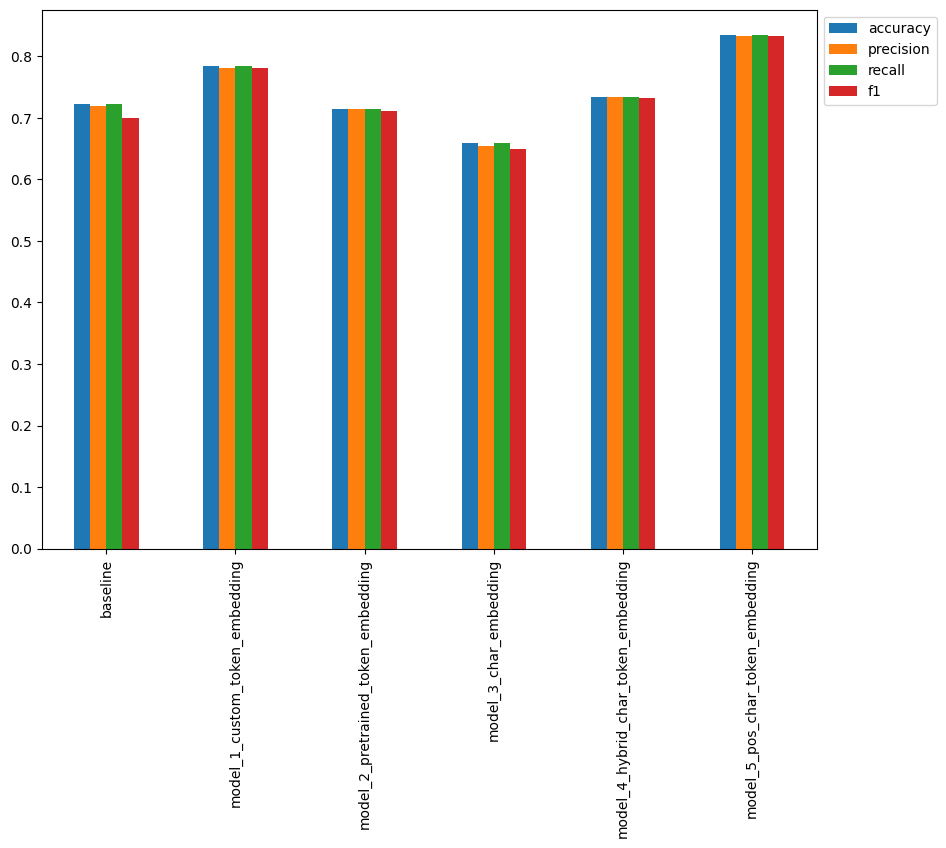

In [120]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=((1.0,1.0)))

<Axes: >

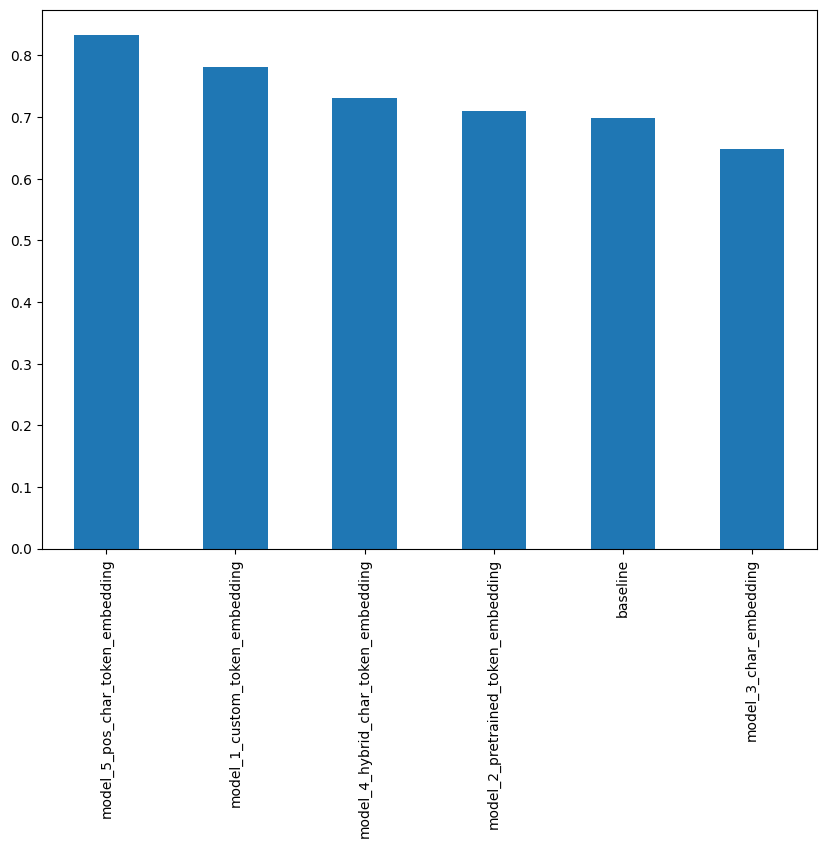

In [121]:
#sort models by f1 score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

In [122]:
#Save the model
model_5.save("skimlit_tribrid_model")

In [123]:
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [124]:
model_5_results

{'accuracy': 83.38077585065537,
 'precision': 0.8325723242110707,
 'recall': 0.8338077585065536,
 'f1': 0.8324938784926226}

In [125]:
loaded_pred_probs=loaded_model.predict(val_char_token_pos_dataset)

945/945 [==============================] - 78s 79ms/step


In [126]:
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [127]:
loaded_model_results=calculate_results(val_label_encoded,loaded_preds)
loaded_model_results

{'accuracy': 83.38077585065537,
 'precision': 0.8325723242110707,
 'recall': 0.8338077585065536,
 'f1': 0.8324938784926226}

In [128]:
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

In [129]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-08-17 15:37:10--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  24.1MB/s    in 40s     

2023-08-17 15:37:50 (22.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [130]:
loaded_gs_model=tf.keras.models.load_model("/content/skimlit_gs_model/skimlit_tribrid_model/")

In [131]:
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 62s 64ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

In [132]:
#challenges
#turn test data into test datasets and evaluate
#most wrong and most correct
#make example predictions(RCT abstracts from the wild)
#Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained),
#make a prediction on each sequence in the abstract and return the abstract in the format:

In [133]:
test_char_token_pos_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_char_token_pos_label=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset=tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_label))
test_char_token_pos_dataset=test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [134]:
loaded_gs_model.evaluate(test_char_token_pos_dataset)
loaded_gs_model

942/942 [==============================] - 64s 68ms/step - loss: 0.9473 - accuracy: 0.8257


In [135]:
loaded_gs_model_pred_probs=loaded_gs_model.predict(test_char_token_pos_dataset)
loaded_gs_model_preds=tf.argmax(loaded_gs_model_pred_probs,axis=1)

942/942 [==============================] - 59s 61ms/step


In [136]:
#create a dataframe with test sentences and best performing model predictions
val_df=pd.DataFrame({"text":test_sentences,
                     "target":test_label_encoded,
                     "pred":loaded_gs_model_preds,
                     "pred_prob":tf.reduce_max(loaded_gs_model_pred_probs,axis=1)})
val_df.head()

,text,target,pred,pred_prob
0,this study analyzed liver function abnormaliti...,0,3,0.523885
1,a post hoc analysis was conducted with the use...,4,3,0.351917
2,liver function tests ( lfts ) were measured at...,4,2,0.802459
3,survival analyses were used to assess the asso...,4,2,0.652782
4,the percentage of patients with abnormal lfts ...,4,4,0.665070


In [137]:
most_wrong=val_df[val_df["target"]!=val_df["pred"]].sort_values("pred_prob",ascending=False)
most_wrong.head()#false positive

,text,target,pred,pred_prob
13874,symptom outcomes will be assessed and estimate...,1,2,0.946719
8545,pretest-posttest .,2,0,0.934974
16347,to evaluate the effects of the lactic acid bac...,0,3,0.930986
2388,the primary endpoint is the cumulative three-y...,4,2,0.928262
10452,to validate the association between accommodat...,0,3,0.918880


In [138]:
most_wrong.tail()#false negative

,text,target,pred,pred_prob
9769,the crystalens ao and restor +@ demonstrated b...,4,2,0.235673
15864,the study showed that the treatment led to imp...,0,2,0.229267
29506,risk factors known to increase the risk of non...,4,0,0.228271
10324,"by relying on the potential of mobile health ,...",0,1,0.215023
19439,it also looks at whether ` feedback-informed t...,0,1,0.212287


In [139]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-08-17 15:41:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-08-17 15:41:51 (65.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [140]:
abstracts=pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [141]:
from spacy.lang.en import English
nlp=English() # setup English sentence parser
sentencizer=nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

In [142]:
doc=nlp(example_abstracts[0]["abstract"])
abstract_lines=[str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [143]:
total_lines_in_sample=len(abstract_lines)
sample_lines=[]
for i,line in enumerate(abstract_lines):
  sample_dict={}
  sample_dict["text"]=str(line)
  sample_dict["line_number"]=i
  sample_dict["total_lines"]=total_lines_in_sample-i
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 8},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 6},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 5},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 4},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 3},
 {'text'

In [169]:
test_abstract_line_numbers=[line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot=tf.one_hot(test_abstract_line_numbers,depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [173]:
test_abstract_total_lines=[line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot=tf.one_hot(test_abstract_total_lines,depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [174]:
abstract_chars=[split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [175]:
test_abstract_pred_probs=loaded_gs_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                 test_abstract_total_lines_one_hot,
                                                 tf.constant(abstract_lines),
                                                 tf.constant(abstract_chars)))

1/1 [==============================] - 3s 3s/step


In [176]:
test_abstract_preds=tf.argmax(test_abstract_pred_probs,axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 2])>

In [179]:
test_abstract_pred_classes=[label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS']

In [180]:
for i,line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}:{line}")

OBJECTIVE:This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS:Participants were randomly assigned to treatment or wait-list conditions.
METHODS:Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS:A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS:Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS:Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS:High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
METHODS:Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
